In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import load

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)


In [4]:
df = pd.read_csv("../data/processed/transactions_features.csv")

with open("../models/model_features_v1.json") as f:
    FEATURES = json.load(f)["features"]

scaler = load("../models/standard_scaler_v1.pkl")

X = scaler.transform(df[FEATURES])
y_true = df["is_fraud"]

print("Data shape:", X.shape)

Data shape: (100000, 9)


In [5]:
X_normal = X[y_true == 0]
print("Normal samples:", X_normal.shape)

Normal samples: (98962, 9)


In [6]:
input_dim = X_normal.shape[1]

inputs = Input(shape=(input_dim,))
x = Dense(64, activation="relu")(inputs)
x = Dense(32, activation="relu")(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(input_dim)(x)

autoencoder = Model(inputs, outputs)

autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse"
)

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,417 (21.16 KB)

 Trainable params: 5,417 (21.16 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = autoencoder.fit(
    X_normal,
    X_normal,
    epochs=15,
    batch_size=256,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)


Epoch 1/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1320 - val_loss: 0.0060
Epoch 2/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0042 - val_loss: 0.0030
Epoch 3/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 4/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 5/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.6604e-04 - val_loss: 7.5833e-04
Epoch 8/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.1613e-04 - val_loss: 6.5925e-04
Epoch 9/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.7428e-04 - val_loss: 5.0580e-04
Epoch 10/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.8658e-04 - val_loss: 0.0011
Epoch 11/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.6736e-04 - val_loss: 7.9754e-04
Epoch 12/15
348/

In [9]:
X_recon = autoencoder.predict(X)
recon_error = np.mean(np.square(X - X_recon), axis=1)

df["ae_score"] = recon_error

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


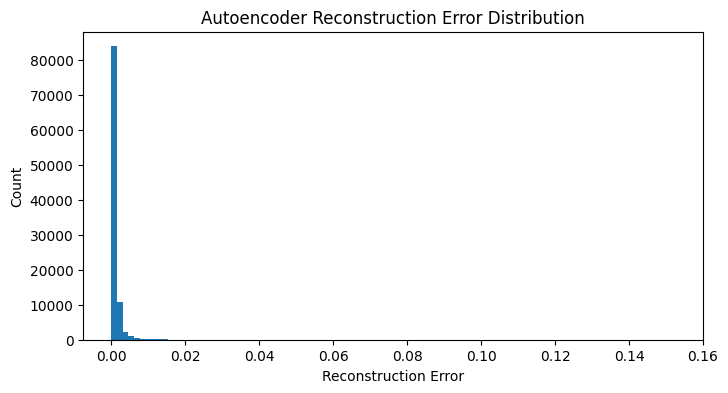

In [10]:
plt.figure(figsize=(8, 4))
plt.hist(recon_error, bins=100)
plt.title("Autoencoder Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.show()


In [17]:
ae_threshold = np.percentile(recon_error, 99)
df["ae_flag"] = df["ae_score"] > ae_threshold

print("Autoencoder anomaly rate:", df["ae_flag"].mean())
ae_threshold

Autoencoder anomaly rate: 0.01


np.float64(0.010299235092751083)

In [12]:
y_pred = df["ae_flag"].astype(int)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, df["ae_score"])

print("Autoencoder Metrics")
print("-------------------")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Autoencoder Metrics
-------------------
Precision: 0.0180
Recall:    0.0173
F1-score:  0.0177
ROC-AUC:   0.5729

Confusion Matrix:
[[97980   982]
 [ 1020    18]]


In [13]:
df.sort_values("ae_score", ascending=False).head(10)[
    FEATURES + ["ae_score", "is_fraud"]
]


,amount_dev_log,avg_amount_24h,txn_count_1h,txn_count_24h,time_since_last_txn_sec,distance_from_home,travel_speed_kmh,hour_sin,hour_cos,ae_score,is_fraud
21340,0.0,599.95,1.0,1.0,6.732395e+06,1735.47,0.930609,0.000000,1.000000e+00,0.152414,0
76537,0.0,392.78,1.0,1.0,3.307757e+06,1731.11,1.893791,-0.866025,5.000000e-01,0.116310,0
30970,0.0,462.84,1.0,1.0,4.708068e+06,1734.42,1.332058,0.965926,-2.588190e-01,0.111267,0
2802,0.0,281.18,1.0,1.0,7.437694e+06,9.71,0.001886,-0.866025,5.000000e-01,0.107925,0
79827,0.0,825.56,1.0,1.0,5.197157e+06,1823.04,1.256888,-0.258819,-9.659258e-01,0.097969,0
38447,0.0,1479.07,1.0,1.0,6.857411e+06,8.20,0.001561,-0.258819,9.659258e-01,0.097328,0
7799,0.0,718.68,1.0,1.0,3.528716e+06,1760.97,1.790798,1.000000,6.123234e-17,0.097253,0
76874,0.0,2169.52,1.0,1.0,7.110608e+06,7.71,0.002081,0.258819,-9.659258e-01,0.096206,0
44996,0.0,363.01,1.0,1.0,7.307777e+06,3.13,0.254643,0.258819,-9.659258e-01,0.094232,0
8996,0.0,529.38,1.0,1.0,7.125515e+06,8.18,0.000483,0.965926,-2.588190e-01,0.093519,0


since autoencoder flags transactions that deviate from learned normal patterns across multiple dimensions. Many of these anomalies correspond to rare but legitimate behaviors, such as long inactivity followed by distant transactions. This leads to low precision when evaluated against fraud labels, but the model is still valuable for identifying behavioral novelty and supporting downstream risk assessment

In [16]:
# Save autoencoder in native Keras format (Keras 3 recommended)
autoencoder.save("../models/autoencoder_v1.keras")

print("Autoencoder saved in Keras format")


Autoencoder saved in Keras format


The autoencoder is flagging structurally rare but not necessarily fraudulent transactions, such as dormant accounts reactivating at unusual times or locations.